In [ ]:
# tutorial url
# https://huggingface.co/blog/time-series-transformers

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("monash_tsf", "tourism_monthly")

Found cached dataset monash_tsf (C:/Users/yozhan/.cache/huggingface/datasets/monash_tsf/tourism_monthly/1.0.0/fc869f3ae1577c9def2a919ab1dd0c3d4a7a44826b8e0e8fa423bb0161b629e2)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
train_example = dataset["train"][0]
print(train_example.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])


In [4]:
print(train_example["start"])
print(train_example["target"])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [5]:
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [6]:
print(validation_example['start'])
print(validation_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [7]:
freq = "1M"
prediction_length = 24

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

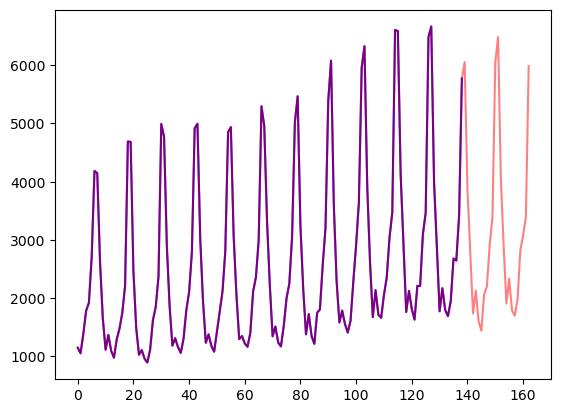

In [8]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

In [9]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [10]:
#lru_cache is a decorator for some recursive calculation
# the values will stored in cache so that cached values will be used in the future if repeating computation happens

from functools import lru_cache

import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [11]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [12]:
"""We specify a couple of additional parameters to the model:

prediction_length (in our case, 24 months): this is the horizon that the decoder of the Transformer will learn to predict for;
context_length: the model will set the context_length (input of the encoder) 
                equal to the prediction_length, if no context_length is specified;
                
lags for a given frequency: these specify how much we "look back", to be added as 
                            additional features. e.g. for a Daily frequency we might consider 
                            a look back of [1, 2, 7, 30, ...] or in other words look back 1, 2, ... 
                            days while for Minute data we might consider [1, 30, 60, 60*24, ...] etc.;
                            
the number of time features: in our case, this will be 2 as we'll add MonthOfYear and Age features;

the number of static categorical features: in our case, this will be just 1 as we'll add a single "time series ID" feature;

the cardinality: the number of values of each static categorical feature, 
                as a list which for our case will be [366] as we have 366 different time series
                
the embedding dimension: the embedding dimension for each static categorical feature, 
                        as a list, for example [3] means the model will learn an embedding 
                        vector of size 3 for each of the 366 time series (regions). """

'We specify a couple of additional parameters to the model:\n\nprediction_length (in our case, 24 months): this is the horizon that the decoder of the Transformer will learn to predict for;\ncontext_length: the model will set the context_length (input of the encoder) \n                equal to the prediction_length, if no context_length is specified;\n                \nlags for a given frequency: these specify how much we "look back", to be added as \n                            additional features. e.g. for a Daily frequency we might consider \n                            a look back of [1, 2, 7, 30, ...] or in other words look back 1, 2, ... \n                            days while for Minute data we might consider [1, 30, 60, 60*24, ...] etc.;\n                            \nthe number of time features: in our case, this will be 2 as we\'ll add MonthOfYear and Age features;\n\nthe number of static categorical features: in our case, this will be just 1 as we\'ll add a single "time ser

In [13]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [14]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x000002DFA39B55A0>]


In [15]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
        
)

model = TimeSeriesTransformerForPrediction(config)

In [16]:
"""
Note that, similar to other models in the 🤗 Transformers library, 
TimeSeriesTransformerModel corresponds to the encoder-decoder Transformer without any head on top, 
and TimeSeriesTransformerForPrediction corresponds to TimeSeriesTransformerModel with a distribution head on top. 
By default, the model uses a Student-t distribution (but this is configurable):
"""

'\note that, similar to other models in the 🤗 Transformers library, \nTimeSeriesTransformerModel corresponds to the encoder-decoder Transformer without any head on top, \nand TimeSeriesTransformerForPrediction corresponds to TimeSeriesTransformerModel with a distribution head on top. \nBy default, the model uses a Student-t distribution (but this is configurable):\n'

In [17]:
model.config.distribution_output

'student_t'

In [18]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [19]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)
    print(remove_field_names)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [20]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [21]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [22]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [23]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

['feat_static_real', 'feat_dynamic_real']
['feat_static_real', 'feat_dynamic_real']


In [24]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
past_values torch.Size([256, 85]) torch.FloatTensor
past_observed_mask torch.Size([256, 85]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.IntTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


In [25]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [26]:
%%time

print("Loss:", outputs.loss.item())

Loss: 9.22168254852295
CPU times: total: 0 ns
Wall time: 1 ms


In [27]:
%%time

from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(1):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

9.025437355041504
CPU times: total: 32min 9s
Wall time: 4min 36s


In [28]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [29]:
print(forecasts[0].shape)

(64, 100, 24)


In [30]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


In [31]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("mase")
smape_metric = load("smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])

In [32]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

MASE: 3.1912513800374036
sMAPE: 0.34196129648343504


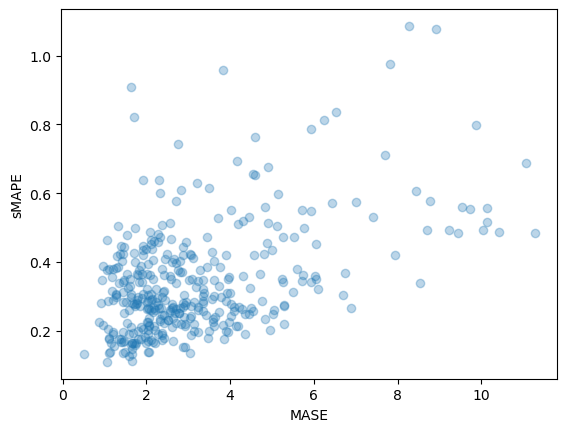

In [33]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [34]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

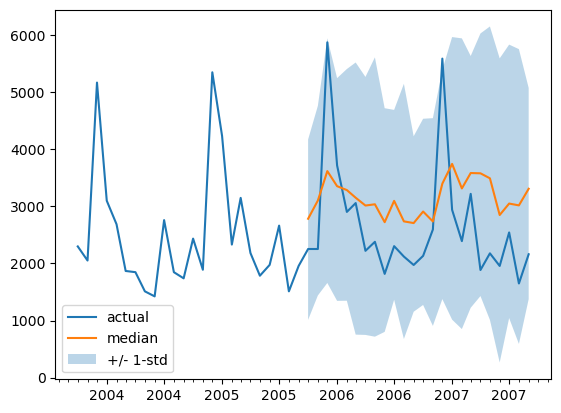

In [35]:
plot(334)